## Import modules

In [1]:
import numpy as np
import os
from numpy import linalg as LA
import librosa
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras import backend as K
import pandas as pd
import cv2
from PIL import Image
import time
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
#from pylab import *
import math

/Users/jaejinan/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Import and save row datas

In [48]:
data_arr = []
levels=os.listdir("./BillData/")
for a in levels:
    try:
        if not a.startswith('.'):
            files = os.listdir("./BillData/"+a)
            files_arr = []
            for b in files:
                try:
                    if not b.startswith('.'):
                        num_arr = []
                        path_to_file = os.path.join("./BillData/"+a, b)
                        fd = open(path_to_file , 'r')
                        while True:
                            string = fd.readline()
                            if not string: break
                            num_arr.append(float(string[:-1]))
                        files_arr.append(num_arr)
                        fd.close()
                except AttributeError:
                    print("")
            data_arr.append(files_arr)
    except AttributeError:
        print("")
        
#data_arr[level_num][file_num][numbers]
#level_num : 0~4(5 classes)
#file_num : 0~79(20*4 files)
#numbers : 0~8799(8800 amplitudes)

In [49]:
Datas=np.array(data_arr)

In [50]:
np.save("Datas",Datas)

## Load row datas

In [3]:
Datas=np.load("Datas.npy")

## 1. Statistical analysis

## Data preprocessing

In [52]:
file_static = []
for a in Datas:
    tmp = []
    for b in a:
        l = len(b)
        m = np.mean(b)
        s = np.std(b)
        sum1 = float(0)
        sum2 = float(0)
        for x in range(0,l):
            sum1 = sum1 + np.power(((b[x] - m)/s),3)
            sum2 = sum2 + np.power(((b[x] - m)/s),4)
        ske = sum1/l
        kur = sum2/l
        static = [s,ske,kur]
        tmp.append(static)
    file_static.append(tmp)
#file_static[level_num][file_num][static]
#level_num : 0~4(5 classes)
#file_num : 0~79(20*4 files)
#static : {0:std,1:ske,2:kur}

In [53]:
level_static = []
for a in Datas:
    tmp = []
    for b in a:
        for c in b:
            tmp.append(c)
    l = len(tmp)
    m = np.mean(tmp)
    s = np.std(tmp)
    sum1 = float(0)
    sum2 = float(0)
    for x in range(0,l):
        sum1 = sum1 + np.power(((tmp[x] - m)/s),3)
        sum2 = sum2 + np.power(((tmp[x] - m)/s),4)
    ske = sum1/l
    kur = sum2/l
    static = [s,ske,kur]
    level_static.append(static)
#level_static[level_num][static]
#level_num : 0~4(5 classes)
#static : {0:std,1:ske,2:kur}

In [54]:
#print(file_static[0][0][0])
#print(file_static[0][0])
#print(level_static[0][0])
#print(level_static)

0.050468285766425064
[[0.050468285766425064, -0.10083737693402064, 23.792985274662254], [0.05338660763257526, 0.17665139690501971, 22.709199045334856], [0.05373410233329576, -0.04564608039504611, 24.70995161419077], [0.08753565072941544, -1.3660862874657225, 28.16299580064359], [0.0588275640969289, -0.4701533008163223, 29.437732711553664]]


## Save processed datas

In [55]:
FS=np.array(file_static)
np.save("file_static",FS)
LS=np.array(level_static)
np.save("level_static",LS)

## Load processed datas

In [3]:
FS=np.load("file_static.npy")
LS=np.load("level_static.npy")

## 1-1. Euclidean distance

In [57]:
ED = []
for a in range(0,len(FS)):
    tmp_1 = []
    for b in FS[a]:
        tmp_2 = []
        for c in LS:
            tmp_2.append(LA.norm(c-b))
        mm=min(tmp_2)
        for i in range(0,len(tmp_2)):
            if(tmp_2[i] == mm):
                tmp_2.append(i)
                if(i == a):
                    tmp_2.append(1)
                else:
                    tmp_2.append(0)
        tmp_1.append(tmp_2)
    ED.append(tmp_1)
#ED[level_num][file_num][distance&result]
#level_num : 0~4(5 classes)
#file_num : 0~79(20*4 files)
#static : {0~4:distance by level,5:result,6:T/F}

In [58]:
count = 0
for a in range(0,len(ED)):
    cou = 0
    for b in ED[a]:
        if(b[6]==1):
            cou = cou + 1
            count = count + 1
    print("level{0}:{1}".format(a,cou/len(ED[0])*100))
print("all:{}".format(count/len(ED[0])/5*100))

level0:0.0
level1:88.75
level2:2.5
level3:13.750000000000002
level4:20.0
all:25.0


In [59]:
from sklearn.metrics import confusion_matrix
test = []
for i in range(0,5):
    for j in range(0,80):
        test.append(i)
pred = []
for a in range(0,len(ED)):
    for b in ED[a]:
        pred.append(b[5])

print(confusion_matrix(test, pred))

[[ 0 69  4  1  6]
 [ 0 71  0  0  9]
 [ 0 67  2  2  9]
 [ 6 34  3 11 26]
 [ 0 60  2  2 16]]


## Visualization of data

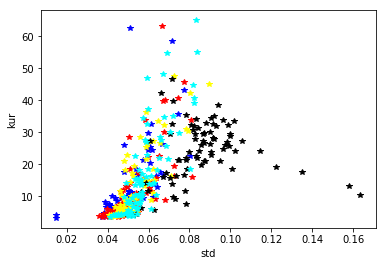

In [60]:
#fig = plt.figure()
#ax = fig.gca(projection='3d')
for a in range(0,len(FS)):
    color=["blue","red","yellow","black","cyan"]
    for b in FS[a] :
        plt.plot(b[0], b[2],c=color[a],marker="*")

plt.xlabel('std')
plt.ylabel('kur')


plt.show()

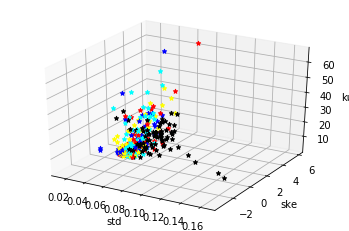

In [61]:
fig = plt.figure()
ax = fig.gca(projection='3d')
for a in range(0,len(FS)):
    color=["blue","red","yellow","black","cyan"]
    for b in FS[a] :
        ax.scatter(b[0], b[1], b[2],c=color[a],marker="*")

ax.set_xlabel('std')
ax.set_ylabel('ske')
ax.set_zlabel('kur')

plt.show()

## 1-2. SVM

In [62]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 0.01, X[:, 0].max() + 0.01
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

## Data processing

In [63]:
import numpy as np
import scipy

STATs = []
Label = []
for a in range(0,len(FS)):
    for b in FS[a]:
        STATs.append([b[0],b[2]])
        Label.append(a)

STATs=np.array(STATs)
Label=np.array(Label)
s=np.arange(STATs.shape[0])
np.random.shuffle(s)
STATs=STATs[s]
Label=Label[s]

## Learning and visualizing

Labels count in Y: [80 80 80 80 80]
Labels counts in Y_train: [56 56 56 56 56]
Labels counts in Y_train: [24 24 24 24 24]


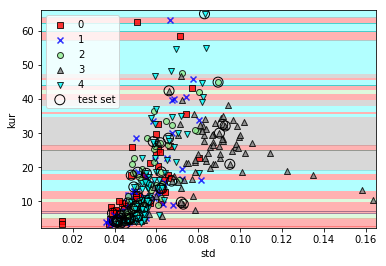

Misclassified samples: 76
Accuracy: 0.37


In [64]:
from sklearn.model_selection import train_test_split
(X_train, X_test, Y_train, Y_test) = train_test_split(STATs ,Label, test_size=0.3, random_state=1, stratify=Label)
print('Labels count in Y:', np.bincount(Label))
print('Labels counts in Y_train:', np.bincount(Y_train))
print('Labels counts in Y_train:', np.bincount(Y_test))

from sklearn.svm import SVC

svm = SVC(kernel='rbf', random_state=1, gamma=1, C=1.0)
svm.fit(X_train, Y_train)

plot_decision_regions(STATs, Label,
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('std')
plt.ylabel('kur')
plt.legend(loc='upper left')
#plt.savefig('./svm.png', dpi=300)
plt.show()

Y_pred = svm.predict(X_test)
print('Misclassified samples: %d' % (Y_test != Y_pred).sum())

from sklearn.metrics import accuracy_score
print('Accuracy: %.2f' % accuracy_score(Y_test, Y_pred))

## Confusion matrix

In [65]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_test, Y_pred))

[[ 9 12  0  2  1]
 [ 7  8  2  3  4]
 [ 6  4  6  2  6]
 [ 5  0  1 12  6]
 [ 2  7  2  4  9]]


## 1-3 Classifier

In [66]:
import numpy as np
import scipy

STATs = []
Label = []
file_static = []
for a in range(0,len(FS)):
    for b in FS[a]:
        STATs.append(b)
        Label.append(a)

STATs=np.array(STATs)
Label=np.array(Label)

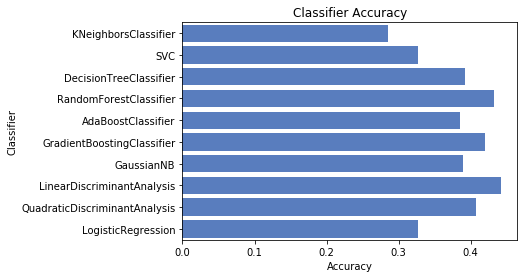

In [379]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

log_cols = ["Classifier", "Accuracy"]
log      = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = STATs
y = Label

acc_dict = {}

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] = acc

for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")
#plt.savefig('./ST.pdf', dpi=600)

## 2. Mel Frequency Cepstral Coefficient (MFCC)

## Data processing

In [368]:
MFCCs = []
Label = []
file_static = []
for a in range(0,len(Datas)):
    for b in Datas[a]:
        mfcc = librosa.feature.mfcc(y=b, sr=44100,n_mfcc=20)
        MFCCs.append(mfcc)
        Label.append(a)

## Save and Load

In [369]:
MFCCs=np.array(MFCCs)
Label=np.array(Label)

In [370]:
np.save("MFCCs",MFCCs)
np.save("Label",Label)

In [371]:
MFCCs=np.load("MFCCs.npy")
Label=np.load("Label.npy")

## 2-1. Euclidean distance

In [372]:
MMFFCCs = []
for i in range(0,5):
    tmp = []
    for j in range(0,80):
        tmp.append(MFCCs[80*i+j])
    MMFFCCs.append(tmp)

MMFFCCss = []
for a in MMFFCCs:
    tmp = []
    for b in a:
        if(len(tmp) == 0):
            tmp.append(b)
        tmp = tmp + b
    tmp= tmp/80
    MMFFCCss.append(tmp)
    
MMFFCCs = np.array(MMFFCCs)
MMFFCCss = np.array(MMFFCCss)
#MMFFCCss[level_num][mfcc]
#level_num : 0~4(5 classes)
#mfcc : 20*18 dataset

#MMFFCCs[level_num][file_num][mfcc]
#level_num : 0~4(5 classes)
#file_num : 0~79(20*4 files)
#mfcc : 20*18 dataset

In [373]:
ED2 = []
for a in range(0,len(MMFFCCs)):
    tmp_1 = []
    for b in MMFFCCs[a]:
        tmp_2 = []
        for c in MMFFCCss:
            tmp_2.append(LA.norm(c-b))
        mm = min(tmp_2)
        for i in range(0,len(tmp_2)):
            if(tmp_2[i] == mm):
                tmp_2.append(i)
                if(i == a):
                    tmp_2.append(1)
                else:
                    tmp_2.append(0)
        tmp_1.append(tmp_2)
    ED2.append(tmp_1)
#ED2[level_num][file_num][distance&result]
#level_num : 0~4(5 classes)
#file_num : 0~79(20*4 files)
#static : {0~4:distance by level,5:result,6:T/F}

In [374]:
count = 0
for a in range(0,len(ED2)):
    cou = 0
    for b in ED2[a]:
        if(b[6]==1):
            cou = cou + 1
            count = count + 1
    print("level{0}:{1}".format(a,cou/len(ED2[0])*100))
print("all:{}".format(count/len(ED2[0])/5*100))

level0:62.5
level1:40.0
level2:46.25
level3:86.25
level4:52.5
all:57.49999999999999


In [375]:
from sklearn.metrics import confusion_matrix
test = []
for i in range(0,5):
    for j in range(0,80):
        test.append(i)
pred = []
for a in range(0,len(ED2)):
    for b in ED2[a]:
        pred.append(b[5])

print(confusion_matrix(test, pred))

[[50 18  8  0  4]
 [21 32 11  0 16]
 [11  8 37  2 22]
 [ 0  2  2 69  7]
 [ 6 12 12  8 42]]


## 2-2. Classifier

In [376]:
MFCCC = []
for a in MFCCs:
    tmp = []
    for b in range(0,len(a)):
        tmp.append(np.mean(a[b]))
    MFCCC.append(tmp)
MFCCC = np.array(MFCCC)

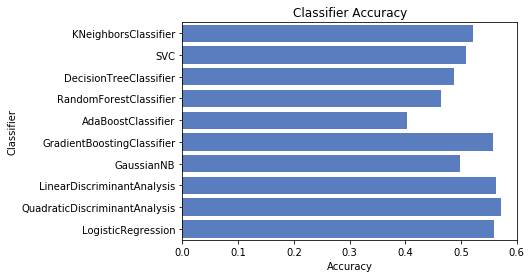

In [378]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

log_cols = ["Classifier", "Accuracy"]
log      = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = MFCCC
y = Label

acc_dict = {}

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] = acc

for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")
#plt.savefig('./MFCC.pdf', dpi=600)

## 3. Graph

In [144]:
'''
os.mkdir('./Images')
for a in range(0,len(Datas)):
    os.mkdir('./Images/LV'+str(a))
'''

In [145]:
'''
for a in range(0,len(Datas)):
    for b in range(0,len(Datas[a])):
        fig = plt.figure()
        plt.plot(Datas[a][b],antialiased=False,color='black',linewidth=0.5)
        plt.axis([0,8800,-1,1])
        plt.tick_params(labelbottom=False,labelleft=False,labelright=False,labeltop=False)
        plt.tick_params(bottom=False,left=False,right=False,top=False)
        plt.box(False)
        plt.savefig('./Images/LV'+str(a)+'/'+str(b+1)+'.png')
        plt.close(fig)
'''

In [111]:
for a in range(0,len(Datas)):
    for b in range(0,len(Datas[a])):
        for c in range(0,8):
            fig = plt.figure()
            plt.plot(Datas[a][b][1100*c:1100*c+1099],antialiased=False,color='black',linewidth=0.5)
            plt.axis([0,1100,-1,1])
            plt.tick_params(labelbottom=False,labelleft=False,labelright=False,labeltop=False)
            plt.tick_params(bottom=False,left=False,right=False,top=False)
            plt.box(False)
            plt.savefig('./Images2/LV'+str(a)+'/'+str(b+1)+'_'+str(c+1)+'.png')
            plt.close(fig)

## 3-1. CNN(Convolutional Neural Network)

## Import and save images

In [246]:
'''
data = []
labels = []
levels=os.listdir("./Images/")
i = 0
for a in levels:
    try:
        if not a.startswith('.'):
            files = os.listdir("./Images/"+a)
            for b in files:
                try:
                    if not b.startswith('.'):
                        path_to_file = os.path.join("./Images/"+a, b)
                        image=cv2.imread(path_to_file)
                        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                        image_from_array = Image.fromarray(gray)
                        data.append(np.array(image_from_array))
                        labels.append(i)
                        fd.close()
                except AttributeError:
                    print("")
            data_arr.append(files_arr)
        i = i + 1
    except AttributeError:
        print("")
'''

In [114]:
data = []
labels = []
levels=os.listdir("./Images2/")
i = 0
for a in levels:
    try:
        if not a.startswith('.'):
            files = os.listdir("./Images2/"+a)
            for b in files:
                try:
                    if not b.startswith('.'):
                        path_to_file = os.path.join("./Images2/"+a, b)
                        image=cv2.imread(path_to_file)
                        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                        image_from_array = Image.fromarray(gray)
                        data.append(np.array(image_from_array))
                        labels.append(i)
                except AttributeError:
                    print("")
        i = i + 1
    except AttributeError:
        print("")

In [115]:
Graph=np.array(data)
labels=np.array(labels)

In [116]:
np.save("Graph",Graph)
np.save("labels",labels)

## Load Images

In [117]:
Graph=np.load("Graph.npy")
labels=np.load("labels.npy")

## Data preprocessing

In [118]:
s=np.arange(Graph.shape[0])
np.random.shuffle(s)
Graph=Graph[s]
labels=labels[s]

In [119]:
num_classes=len(np.unique(labels))
len_data=len(Graph)

In [120]:
(x_train,x_test)=Graph[(int)(0.1*len_data):],Graph[:(int)(0.1*len_data)]
x_train = x_train.astype('float32')/255 # As we are working on image data we are normalizing data by divinding 255.
x_test = x_test.astype('float32')/255
train_len=len(x_train)
test_len=len(x_test)

In [121]:
(y_train,y_test)=labels[(int)(0.1*len_data):],labels[:(int)(0.1*len_data)]

# Visualization of data 

In [122]:
#preparing label name
label = np.array([
    'Lv0',
    'Lv1',
    'Lv2',
    'Lv3',
    'Lv4'])

In [123]:
#Store 10 images for each label
img_list = []
for for_1 in range(5):
    choice_idx = np.random.choice(np.where(y_test == for_1)[0], 5)
    img_list.append(x_test[choice_idx])

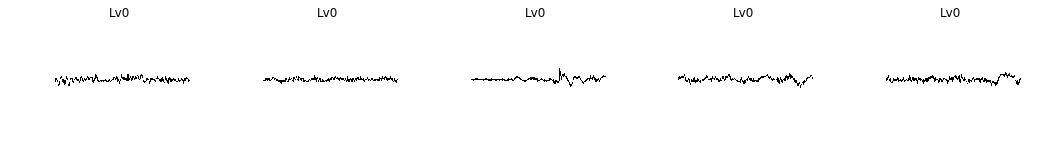

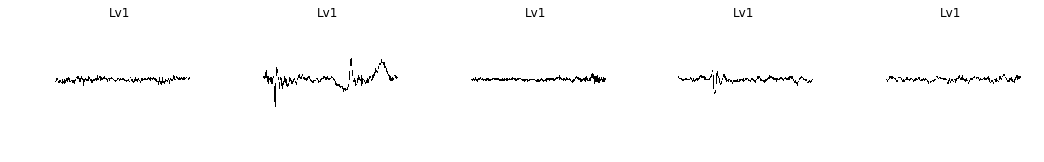

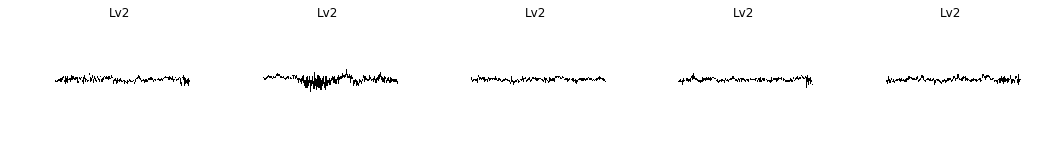

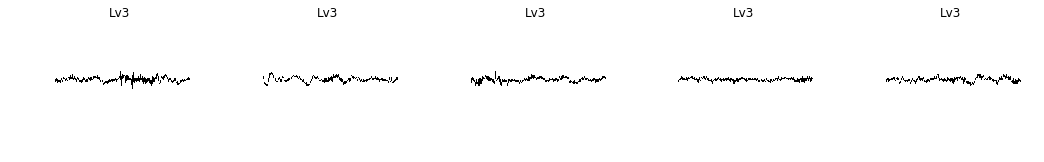

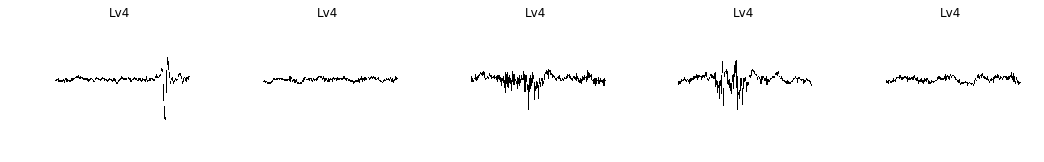

In [124]:
# Visualization of data
for for_1 in range(5):
    fig, ax = plt.subplots(1, 5, figsize=(18, 8))
    for for_2 in range(5):
        ax[for_2].imshow(img_list[for_1][for_2],cmap='gray') #Outputs the nth and subsequent test data with the value of for_2 + n
        ax[for_2].set_title(label[for_1])
        ax[for_2].axis('off')

In [125]:
y_train=keras.utils.to_categorical(y_train,num_classes)
y_test=keras.utils.to_categorical(y_test,num_classes)

In [126]:
img_rows, img_cols = 288,432
img_channels = 1
# Adjustment of input type of dimension number due to difference of backend

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [127]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(12, 12), activation="relu", input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(6,6)))
model.add(Conv2D(32, kernel_size=(6, 6), activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(64, kernel_size=(4, 4), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [128]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 277, 421, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 46, 70, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 41, 65, 32)        36896     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 21, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 18, 64)        32832     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 9, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2880)              0         
__________

## Set model optimization function and error function

In [129]:
from keras.optimizers import SGD, Adadelta, Adam, RMSprop

# model.compile(loss='categorical_crossentropy', 
#               optimizer='SGD', 
#               metrics=['accuracy'])
model.compile(loss="categorical_crossentropy", # 誤差(損失)関数
             optimizer="adam", # 最適化関数
             metrics=["accuracy"] # 評価指標
             )

## Save model and parameters

In [139]:
#Save model in JSON format
json_string = model.to_json()
open('./sound.json', 'w').write(json_string)

3677

In [140]:
#Save initial weight
model.save_weights('./sound.hdf5', overwrite=True)

## Reading models and calling parameters

In [141]:
# from keras.models import model_from_json, model_from_yaml
# #Calling models saved in JSON format
# json_string = open('./sound.json', 'r').read()
# model = model_from_json(json_string)
# model.load_weights('./sound.hdf5')

## Learning

In [142]:
#See progress of learning at TensorBoard
tb_cb = keras.callbacks.TensorBoard(log_dir='./', histogram_freq=1)

# If the validation loss decreases, save the model for each epoch
cp_cb = keras.callbacks.ModelCheckpoint(filepath='./sound.hdf5', 
                                        monitor='val_loss', 
                                        verbose=1, 
                                        save_best_only=True, 
                                        mode='auto')

# If the validation loss rises for 5 epochs in a row, the run is aborted
es_cb = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=5, 
                                      verbose=0, 
                                      mode='auto')

cbks = [tb_cb, cp_cb, es_cb]

In [146]:
#Perform learning
#The value of loss function in learning is stored in history.history
history = model.fit(x_train, y_train,
                    batch_size=64,  #128 datas are randomly obtained
                    nb_epoch=50, #Number of trials
                    verbose=1,
                    validation_data=(x_test, y_test),
                    validation_split=0.1,
                    callbacks=cbks
                    )

/Users/jaejinan/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 2880 samples, validate on 320 samples
Epoch 1/50
2880/2880 [==============================] - 474s 165ms/step - loss: 1.2899 - acc: 0.4076 - val_loss: 1.3472 - val_acc: 0.3719

Epoch 00001: val_loss improved from inf to 1.34716, saving model to ./sound.hdf5
Epoch 2/50
2880/2880 [==============================] - 462s 160ms/step - loss: 1.2534 - acc: 0.4337 - val_loss: 1.3465 - val_acc: 0.3781

Epoch 00002: val_loss improved from 1.34716 to 1.34653, saving model to ./sound.hdf5
Epoch 3/50
2880/2880 [==============================] - 460s 160ms/step - loss: 1.2437 - acc: 0.4347 - val_loss: 1.3747 - val_acc: 0.3594

Epoch 00003: val_loss did not improve from 1.34653
Epoch 4/50
2880/2880 [==============================] - 475s 165ms/step - loss: 1.2384 - acc: 0.4358 - val_loss: 1.3562 - val_acc: 0.3563

Epoch 00004: val_loss did not improve from 1.34653
Epoch 5/50
2880/2880 [==============================] - 468s 163ms/step - loss: 1.2207 - acc: 0.4365 - val_loss: 1.3816 - val_acc

## Calling the best parameter

In [136]:
model.load_weights('./sound.hdf5')

## Evaluation of learning result

In [137]:
#Evaluation value for test data
score = model.evaluate(x_test, y_test, verbose=0)
print('Test score:', score[0]) #The value of the loss function
print('Test accuracy:', score[1]) #Accuracy (over 98%)

Test score: 1.3685287952423095
Test accuracy: 0.3625


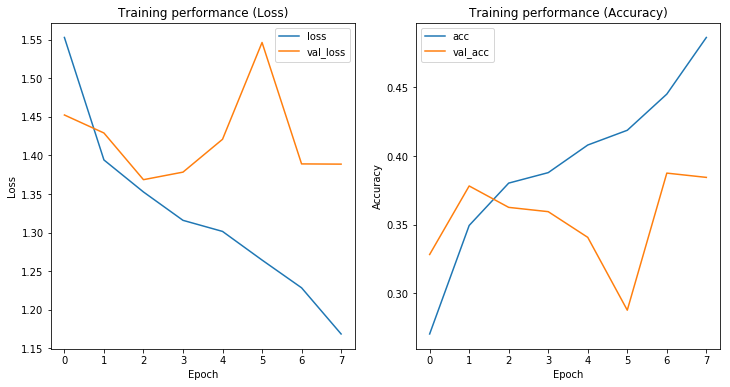

In [138]:
#Learning curve
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('Training performance (Loss)')
ax[0].plot(history.epoch, history.history['loss'], label='loss')
ax[0].plot(history.epoch, history.history['val_loss'], label='val_loss')
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[0].legend()

ax[1].set_title('Training performance (Accuracy)')
ax[1].plot(history.epoch, history.history['acc'], label='acc')
ax[1].plot(history.epoch, history.history['val_acc'], label='val_acc')
ax[1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1].legend(loc='best')

#plt.savefig('./image_cnn.pdf', dpi=600)

## Predictive visualization

In [28]:
#Predicted value
#Store 10 images for each label
New_test = []
for for_1 in range(10):
    choice_idx = np.random.choice(np.where(y_test == (for_1%2))[0])
    New_test.append(x_test[choice_idx])
New_test = np.array(New_test)
# Estimate the label of the image
Y_test_pred = model.predict(New_test)

In [29]:
New_test = New_test.reshape(New_test.shape[0], img_rows, img_cols)

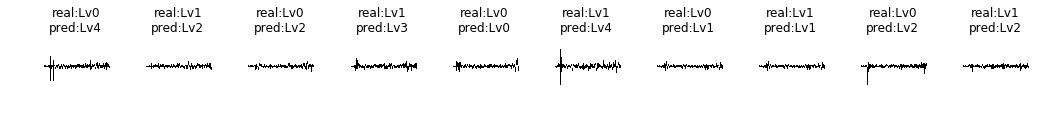

In [30]:
#Data visualization
#The upper row is the correct label, and lower row is the guess label
fig, ax = plt.subplots(1, 10, figsize=(18, 8))
for for_1 in range(10):
    ax[for_1].imshow(New_test[for_1],cmap='gray') #Outputs the nth and subsequent test data with the value of for_2 + n
    ax[for_1].set_title("real:"+str(label[(for_1%2)])+"\npred:"+str(label[np.argmax(Y_test_pred[for_1])]))
    ax[for_1].axis('off')

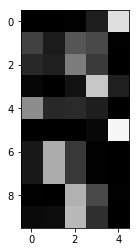

In [31]:
#Predictive visualization
#Numerals of images passed by Y axis, and X axis is estimated by neural network
plt.imshow(Y_test_pred[:10], cmap='gray', interpolation='nearest', vmin=0, vmax=1) #Y_test_predの範囲を変えることで予測の場所を変更できる

## 4.Difference

## 4-1. AMP by time

In [83]:
Diff_t=[]
la_t = []
for for_1 in range(0,len(Datas)): 
    for for_2 in range(0,len(Datas[0])):   
        tmp = np.zeros(51)
        _X_ = Datas[for_1][for_2][2:]-Datas[for_1][for_2][1:8799]
        _Y_ = Datas[for_1][for_2][1:8799]-Datas[for_1][for_2][:8798]
        _R_ = np.sqrt(_X_*_X_ + _Y_*_Y_)
        for a in _R_:
            if(0<=a<=0.125):
                tmp[int(a/0.0025)] = tmp[int(a/0.0025)] + 1
            elif(a>0.125):
                tmp[50] = tmp[50] + 1
        Diff_t.append(tmp)
        la_t.append(for_1)

In [84]:
Diff_t = np.array(Diff_t)
la_t = np.array(la_t)

(400, 51)
[171. 471. 693. 826. 867. 872. 805. 672. 664. 510. 410. 351. 265. 209.
 161. 144. 139. 105.  76.  61.  71.  37.  31.  21.  24.  21.  20.  11.
  17.   7.   7.   7.   8.   5.   6.   3.   1.   4.   1.   1.   1.   1.
   4.   2.   0.   0.   0.   1.   1.   0.  13.]
0 1 2 3


/Users/jaejinan/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/jaejinan/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/jaejinan/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/jaejinan/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/jaejinan/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/jaejinan/.pyenv/v

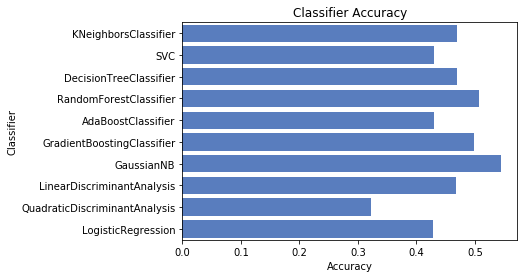

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

log_cols = ["Classifier", "Accuracy"]
log      = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = Diff_t
y = la_t

acc_dict = {}

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] = acc

for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")
#plt.savefig('./Diff.pdf', dpi=600)

## 4-2. AMP by Freq(Fourier transform)

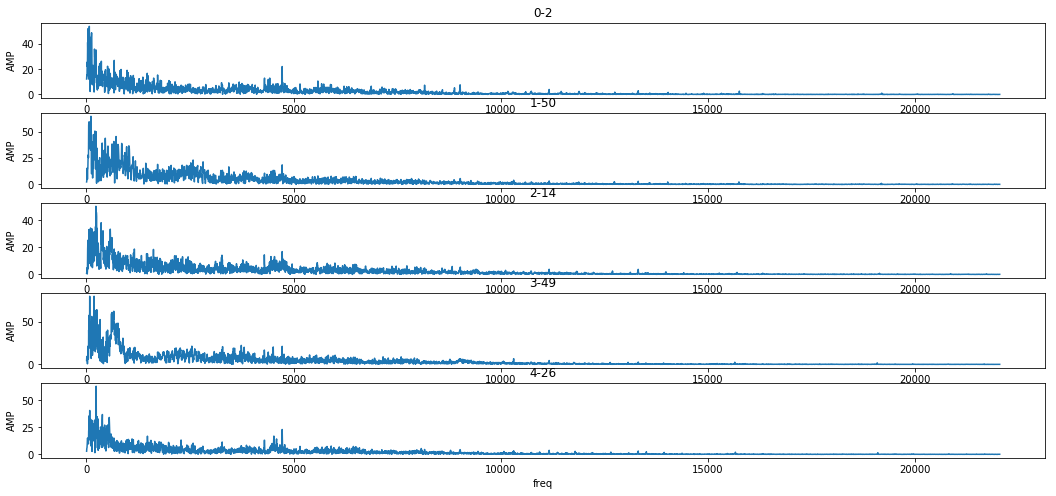

In [78]:
fig, ax = plt.subplots(5, 1, figsize=(18, 8))
for for_1 in range(0,len(Datas)):
    fi_nu = random.randrange(1,80)
    Y = np.fft.fft(Datas[for_1][fi_nu][:])
    N = int(len(Y)/2)
    Y[0] = None
    AMP = np.abs(Y[0:N])
    nyquist = 1/2*44100
    freq = np.arange(0, N, 1)/(N)*nyquist
    ax[for_1].plot(freq, AMP)
    ax[for_1].set_title(str(for_1) +"-"+ str(fi_nu+1))
    #ax[for_1].axis([-0.001,44101,-0.001,10000])
    ax[for_1].set_ylabel('AMP')
    ax[for_1].set_xlabel('freq')
#plt.savefig('./fft1.pdf', dpi=300)

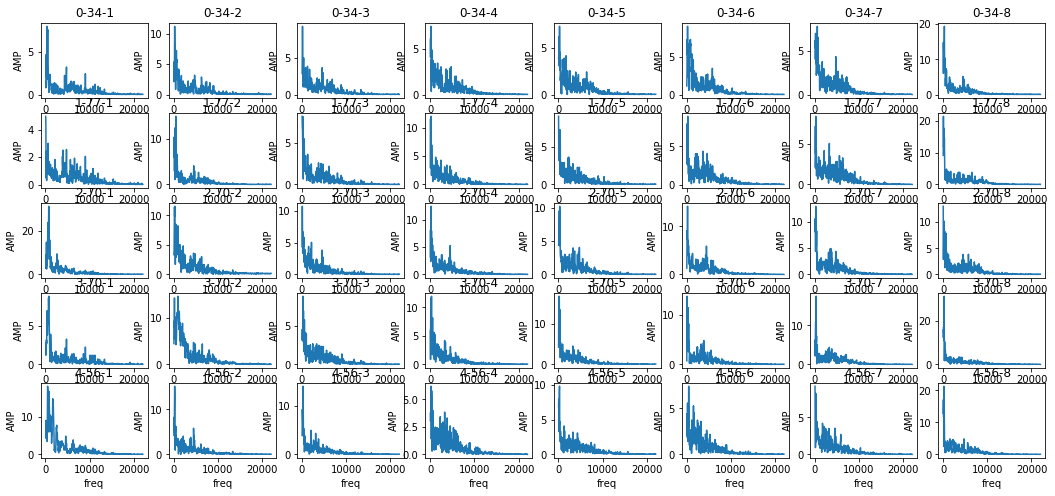

In [82]:
fig, ax = plt.subplots(5, 8, figsize=(18, 8))
for for_1 in range(0,len(Datas)):
    fi_nu = random.randrange(1,80)
    for for_2 in range(8):
        Y = np.fft.fft(Datas[for_1][fi_nu][for_2*1024+0:for_2*1024+1023])
        N = int(len(Y)/2)
        Y[0] = None
        AMP = np.abs(Y[0:N])
        nyquist = 1/2*44100
        freq = np.arange(0, N, 1)/(N)*nyquist
        ax[for_1][for_2].plot(freq, AMP)
        ax[for_1][for_2].set_title(str(for_1) +"-"+ str(fi_nu+1) +"-"+ str(for_2+1))
        #ax[for_1][for_2].axis([-0.001,44100,-0.001,500])
        ax[for_1][for_2].set_ylabel('AMP')
        ax[for_1][for_2].set_xlabel('freq')
        
#plt.savefig('./fft2.pdf', dpi=600)

In [49]:
Diff=[]
la = []
for for_1 in range(0,len(Datas)):
    for for_2 in range(0,len(Datas[0])):
        tmp = []
        for for_3 in range(7):
            Y = np.fft.fft(Datas[for_1][for_2][for_3*1024+0:for_3*1024+1023])
            Z = np.fft.fft(Datas[for_1][for_2][for_3*1024+512:for_3*1024+1535])
            W = np.fft.fft(Datas[for_1][for_2][for_3*1024+1024:for_3*1024+2047])
            N = int(len(Y)/2)
            Y[0] = None
            Z[0] = None
            W[0] = None
            _X_ = np.abs(np.abs(W[0:N])-np.abs(Z[0:N]))[1:256]
            _Y_ = np.abs(np.abs(Z[0:N])-np.abs(Y[0:N]))[1:256]
            _R_ = np.sum(_X_ + _Y_)
            tmp.append(_R_)
        Diff.append(tmp)
        la.append(for_1) 

In [53]:
Diff = np.array(Diff)
la = np.array(la)

[318.84325554 274.53349967 285.30424052 286.44572323 345.67197463
 318.71231605 386.06390487]
0 1 2 3


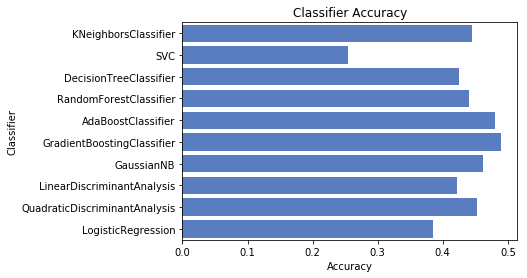

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

log_cols = ["Classifier", "Accuracy"]
log      = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = Diff
y = la

acc_dict = {}

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] = acc

for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")
#plt.savefig('./Diff.pdf', dpi=600)